In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import pipeline
import os
from tqdm.notebook import tqdm
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Loading Data

In [2]:

df = pd.read_csv("./data/regulations_docket (4).csv")

# EDA

In [3]:
df.head(2)

,Document ID,Agency ID,Docket ID,Tracking Number,Document Type,Posted Date,Is Withdrawn?,Federal Register Number,FR Citation,Title,Comment Start Date,Comment Due Date,Allow Late Comments,Comment on Document ID,Effective Date,Implementation Date,Postmark Date,Received Date,Author Date,Related RIN(s),Authors,CFR,Abstract,Legacy ID,Media,Document Subtype,Exhibit Location,Exhibit Type,Additional Field 1,Additional Field 2,Topics,Duplicate Comments,OMB/PRA Approval Number,Page Count,Page Length,Paper Width,Special Instructions,Source Citation,Start End Page,Subject,First Name,Last Name,City,State/Province,Zip/Postal Code,Country,Organization Name,Submitter Representative,Representative's Address,"Representative's City, State & Zip",Government Agency,Government Agency Type,Comment,Category,Restrict Reason Type,Restrict Reason,Reason Withdrawn,Content Files,Attachment Files,"Display Properties (Name, Label, Tooltip)"
0,EPA-R10-OW-2017-0369-0001,EPA,EPA-R10-OW-2017-0369,NaN,Notice,2017-07-19T04:00Z,False,2017-15181,82.0,Proposed Determination to Restrict Use of Area...,2017-07-19T04:00Z,2017-10-18T03:59:59Z,False,NaN,NaN,NaN,NaN,2017-07-19T04:00Z,NaN,NaN,NaN,NaN,"Federal Register of July 19, 2017, (82 FR 3312...",NaN,NaN,Request for Comments,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,33123 - 33124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/EPA-R10-OW-2...,NaN,"pageCount, Page Count, Number of pages In the ..."
1,EPA-R10-OW-2017-0369-0003,EPA,EPA-R10-OW-2017-0369,1k1-8xlx-cjp9,Public Submission,2017-07-21T04:00Z,False,NaN,NaN,Anonymous public comment,NaN,NaN,False,EPA-R10-OW-2017-0369-0001,NaN,NaN,2017-07-19T04:00Z,2017-07-19T04:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Public Comment,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Subject: EPA-R10-OW-2017-0369 Preserve Bristol...,NaN,NaN,NaN,NaN,NaN,NaN,"pageCount, Page Count, Number of pages In the ..."


In [4]:
# Filtering down to interesting columns
non_zero_cols = []
for col in df.columns:
    if  df[col].nunique()>1:
        non_zero_cols.append(col)
        print(col, df[col].nunique())
df[non_zero_cols]

Document ID 3391
Tracking Number 3381
Document Type 3
Posted Date 48
Is Withdrawn? 2
Federal Register Number 4
FR Citation 3
Title 717
Comment Start Date 2
Comment on Document ID 2
Postmark Date 88
Received Date 93
Author Date 9
Authors 4
Abstract 43
Document Subtype 14
Duplicate Comments 19
Page Count 11
Start End Page 4
Comment 3269
Content Files 28
Attachment Files 67
Display Properties (Name, Label, Tooltip) 2


,Document ID,Tracking Number,Document Type,Posted Date,Is Withdrawn?,Federal Register Number,FR Citation,Title,Comment Start Date,Comment on Document ID,Postmark Date,Received Date,Author Date,Authors,Abstract,Document Subtype,Duplicate Comments,Page Count,Start End Page,Comment,Content Files,Attachment Files,"Display Properties (Name, Label, Tooltip)"
0,EPA-R10-OW-2017-0369-0001,NaN,Notice,2017-07-19T04:00Z,False,2017-15181,82.0,Proposed Determination to Restrict Use of Area...,2017-07-19T04:00Z,NaN,NaN,2017-07-19T04:00Z,NaN,NaN,"Federal Register of July 19, 2017, (82 FR 3312...",Request for Comments,NaN,2.0,33123 - 33124,NaN,https://downloads.regulations.gov/EPA-R10-OW-2...,NaN,"pageCount, Page Count, Number of pages In the ..."
1,EPA-R10-OW-2017-0369-0003,1k1-8xlx-cjp9,Public Submission,2017-07-21T04:00Z,False,NaN,NaN,Anonymous public comment,NaN,EPA-R10-OW-2017-0369-0001,2017-07-19T04:00Z,2017-07-19T04:00Z,NaN,NaN,NaN,Public Comment,1.0,1.0,NaN,Subject: EPA-R10-OW-2017-0369 Preserve Bristol...,NaN,NaN,"pageCount, Page Count, Number of pages In the ..."
2,EPA-R10-OW-2017-0369-0004,1k1-8xm3-v0xi,Public Submission,2017-07-21T04:00Z,False,NaN,NaN,Anonymous public comment,NaN,EPA-R10-OW-2017-0369-0001,2017-07-19T04:00Z,2017-07-19T04:00Z,NaN,NaN,NaN,Public Comment,1.0,1.0,NaN,Do not let this happen.. Copper mining need no...,NaN,NaN,"pageCount, Page Count, Number of pages In the ..."
3,EPA-R10-OW-2017-0369-0005,1k1-8xmd-18hj,Public Submission,2017-07-21T04:00Z,False,NaN,NaN,Anonymous public comment,NaN,EPA-R10-OW-2017-0369-0001,2017-07-20T04:00Z,2017-07-20T04:00Z,NaN,NaN,NaN,Public Comment,1.0,1.0,NaN,This area is too important to salmon fishing t...,NaN,NaN,"pageCount, Page Count, Number of pages In the ..."
4,EPA-R10-OW-2017-0369-0006,1k1-8xmg-in4u,Public Submission,2017-07-21T04:00Z,False,NaN,NaN,Anonymous public comment,NaN,EPA-R10-OW-2017-0369-0001,2017-07-20T04:00Z,2017-07-20T04:00Z,NaN,NaN,NaN,Public Comment,1.0,1.0,NaN,An open pit copper mine like the Pebble Mine l...,NaN,NaN,"pageCount, Page Count, Number of pages In the ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386,EPA-R10-OW-2017-0369-9066,1k1-8za0-jkra,Public Submission,2017-10-28T04:00Z,False,NaN,NaN,Anonymous public comment,NaN,EPA-R10-OW-2017-0369-0001,2017-10-17T04:00Z,2017-10-17T04:00Z,NaN,NaN,NaN,Public Comment,1.0,1.0,NaN,We need to keep this area off-limits for a var...,NaN,NaN,"pageCount, Page Count, Number of pages In the ..."
3387,EPA-R10-OW-2017-0369-9067,1k1-8za0-lprw,Public Submission,2017-10-28T04:00Z,False,NaN,NaN,Anonymous public comment,NaN,EPA-R10-OW-2017-0369-0001,2017-10-17T04:00Z,2017-10-17T04:00Z,NaN,NaN,NaN,Public Comment,1.0,1.0,NaN,Clean water protections are essential for Bris...,NaN,NaN,"pageCount, Page Count, Number of pages In the ..."
3388,EPA-R10-OW-2017-0369-9068,1k1-8za0-9b3q,Public Submission,2017-10-28T04:00Z,False,NaN,NaN,Anonymous public comment,NaN,EPA-R10-OW-2017-0369-0001,2017-10-17T04:00Z,2017-10-17T04:00Z,NaN,NaN,NaN,Public Comment,1.0,1.0,NaN,This mine is unacceptable. It will cause catas...,NaN,NaN,"pageCount, Page Count, Number of pages In the ..."
3389,EPA-R10-OW-2017-0369-9458,1k1-8z9y-tp1t,Public Submission,2017-10-31T04:00Z,False,NaN,NaN,"Comment submitted by Robert L. Baldwin, Presid...",NaN,EPA-R10-OW-2017-0369-0001,2017-10-17T04:00Z,2017-10-17T04:00Z,NaN,NaN,NaN,Company/Organization Comment,1.0,1.0,NaN,The Kenai River Watershed Foundation is strong...,NaN,NaN,"pageCount, Page Count, Number of pages In the ..."


In [5]:
cols = [
 'Document Type',
 'Posted Date',
 'Is Withdrawn?',
 'Title',
 'Postmark Date',
 'Received Date',
 'Author Date',
 'Document Subtype',
 'Comment',
 'Content Files',
 'Attachment Files']

In [6]:
#THese lead to comments that are replaced with Na, so need to be filtered out
df[df['Is Withdrawn?']]

,Document ID,Agency ID,Docket ID,Tracking Number,Document Type,Posted Date,Is Withdrawn?,Federal Register Number,FR Citation,Title,Comment Start Date,Comment Due Date,Allow Late Comments,Comment on Document ID,Effective Date,Implementation Date,Postmark Date,Received Date,Author Date,Related RIN(s),Authors,CFR,Abstract,Legacy ID,Media,Document Subtype,Exhibit Location,Exhibit Type,Additional Field 1,Additional Field 2,Topics,Duplicate Comments,OMB/PRA Approval Number,Page Count,Page Length,Paper Width,Special Instructions,Source Citation,Start End Page,Subject,First Name,Last Name,City,State/Province,Zip/Postal Code,Country,Organization Name,Submitter Representative,Representative's Address,"Representative's City, State & Zip",Government Agency,Government Agency Type,Comment,Category,Restrict Reason Type,Restrict Reason,Reason Withdrawn,Content Files,Attachment Files,"Display Properties (Name, Label, Tooltip)"
1671,EPA-R10-OW-2017-0369-4603,EPA,EPA-R10-OW-2017-0369,NaN,Public Submission,2017-10-20T00:00Z,True,NaN,NaN,Contains obscene language,NaN,NaN,False,EPA-R10-OW-2017-0369-0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Contains foul language,NaN,NaN,NaN
2836,EPA-R10-OW-2017-0369-6258,EPA,EPA-R10-OW-2017-0369,NaN,Public Submission,2017-10-24T00:00Z,True,NaN,NaN,Contains obscene language,NaN,NaN,False,EPA-R10-OW-2017-0369-0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Contains foul language,NaN,NaN,NaN


In [7]:
# Some people seem to have posted multiple comments or have had organization post on their behalf. 
# df[df.Title == 'Comment submitted by M. Miller' ].Comment.values
# df[df.Title == 'Mass comment campaign sponsoring organization unknown. Sample attached (web)' ].Comment.values

In [8]:
df['Document Subtype'].value_counts().head(10)

Document Subtype
Public Comment                                      3301
Company/Organization Comment                          31
Mass Mail Campaign                                    25
Public Hearing Transcript, Deposition, Testimony       8
Meeting Materials                                      8
Letter                                                 4
Government Federal                                     2
Report                                                 2
Request for Comments                                   1
Late Comment                                           1
Name: count, dtype: int64

In [9]:
df['Document Type'].value_counts()

Document Type
Public Submission                3363
Supporting & Related Material      24
Notice                              4
Name: count, dtype: int64

In [10]:
# For this I'm filtering down to just vlaid comments
comment_df  = df[(df['Document Type'] == 'Public Submission')&(df['Is Withdrawn?'] == False)&(df['Document Subtype'] == 'Public Comment')]
len(comment_df)

3301

In [11]:
#cleaning up comments
def clean_text(text):
    if pd.isna(text):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning
comment_df['cleaned_comments'] = comment_df['Comment'].apply(clean_text)

C:\Users\dpc50\AppData\Local\Temp\ipykernel_7268\2680575885.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_df['cleaned_comments'] = comment_df['Comment'].apply(clean_text)


In [12]:
comment_df.cleaned_comments.isna().mean()

np.float64(0.0)

In [13]:
#looking at some characteristics of the comments
comment_df['comment_char_length'] = comment_df.cleaned_comments.fillna("").apply(lambda x: len(x))
comment_df['comment_word_length'] = comment_df.cleaned_comments.fillna("").apply(lambda x: len(x.split(" ")))
comment_df = comment_df[comment_df.comment_word_length>1]

C:\Users\dpc50\AppData\Local\Temp\ipykernel_7268\3046931458.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_df['comment_char_length'] = comment_df.cleaned_comments.fillna("").apply(lambda x: len(x))
C:\Users\dpc50\AppData\Local\Temp\ipykernel_7268\3046931458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_df['comment_word_length'] = comment_df.cleaned_comments.fillna("").apply(lambda x: len(x.split(" ")))


In [14]:
comment_df.comment_word_length.mean(), comment_df.comment_word_length.min(), comment_df.comment_word_length.max()

(np.float64(128.13770094024872), 2, 1249)

In [15]:
comment_df.comment_char_length.mean(), comment_df.comment_char_length.min(), comment_df.comment_char_length.max()

(np.float64(782.9896875947832), 11, 4999)

In [16]:
#looking at the distribution of both the word count and lenth of comments we see a bimodal peak


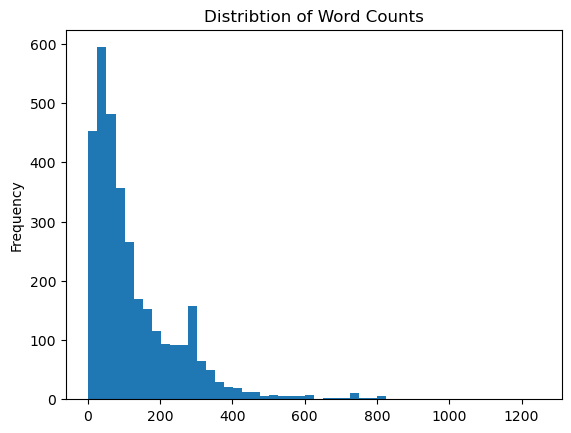

In [17]:
comment_df.comment_word_length.plot(kind = 'hist', bins = 50)
plt.title("Distribtion of Word Counts")
plt.show()

Text(0.5, 1.0, 'Distribution of Character Lengths')

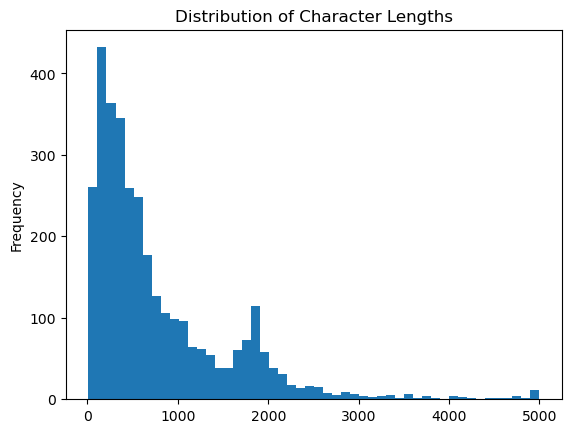

In [18]:

comment_df.comment_char_length.plot(kind = 'hist', bins = 50)
plt.title("Distribution of Character Lengths")

In [19]:
#26 comments contained the exact same text
comment_df.cleaned_comments.value_counts().head(1)

cleaned_comments
i am opposed to epas proposal to rescind the 2014 proposed determination designed to protect bristol bays world class fisheries. please stand with american jobs and communities and preserve the bristol bay proposed determination. bristol bay, alaska, is one of america's last great wild salmon fisheries. each year, tens of millions of wild salmon return, supporting upwards of 14,000 jobs in the commercial and sport fishing industries, and serving as a one-in-a-lifetime destination for anglers from around the world as well as the cultural cornerstone for the region's communities. these long-established businesses are at risk from a foreign-owned mining company that wants to build the proposed pebble mine, which is opposed by more than 65 percent of alaskans and more than 80 percent of bristol bay residents. in 2014, led by alaska native tribes, interests including commercial fishing business owners and sportsmen asked the epa step in to ensure that this mine wouldn't jeo

In [20]:
#235 comments contain the first sentence of the text exactly
comment_df.cleaned_comments.str.contains('i am opposed to epas proposal to rescind the 2014 proposed determination designed to protect bristol bays world class fisheries').sum()

np.int64(235)

In [21]:
#these messages have larger word count and character length charactarsitcs
comment_df[comment_df.cleaned_comments.str.contains('i am opposed to epas proposal to rescind the 2014 proposed determination designed to protect bristol bays world class fisheries')][['comment_word_length','comment_char_length']].mean()

comment_word_length     272.200000
comment_char_length    1757.476596
dtype: float64

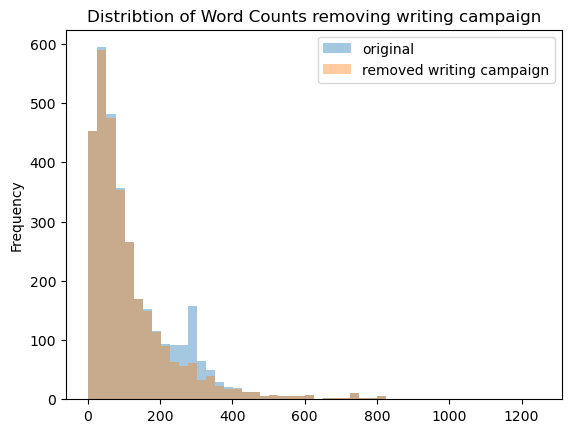

In [22]:
# the second peak can be seen as part of a write in campaign that created around 166 additional comments it largely the same langauge, but does have some individual customization between comments
test_df = comment_df.copy()
test_df = test_df[~test_df.cleaned_comments.str.contains('i am opposed to epas proposal to rescind the 2014 proposed determination designed to protect bristol bays world class fisheries')]
comment_df.comment_word_length.plot(kind = 'hist', bins = 50, alpha = 0.4, label = 'original')

test_df.comment_word_length.plot(kind = 'hist', bins = 50, alpha = 0.4, label = 'removed writing campaign')
plt.legend()
plt.title("Distribtion of Word Counts removing writing campaign")
plt.show()

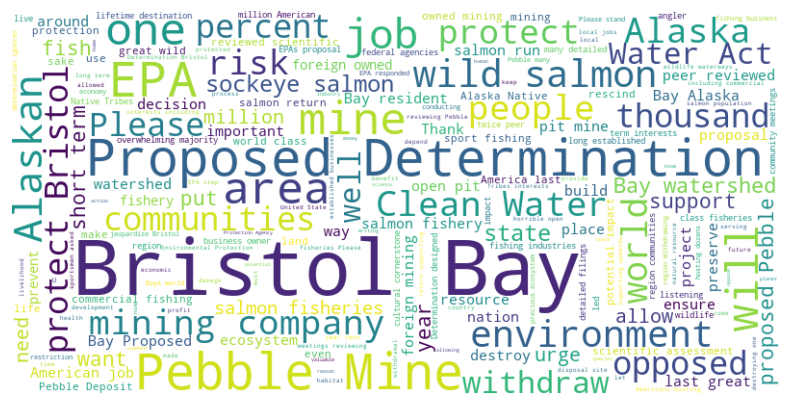

In [23]:

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(comment_df.Comment))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

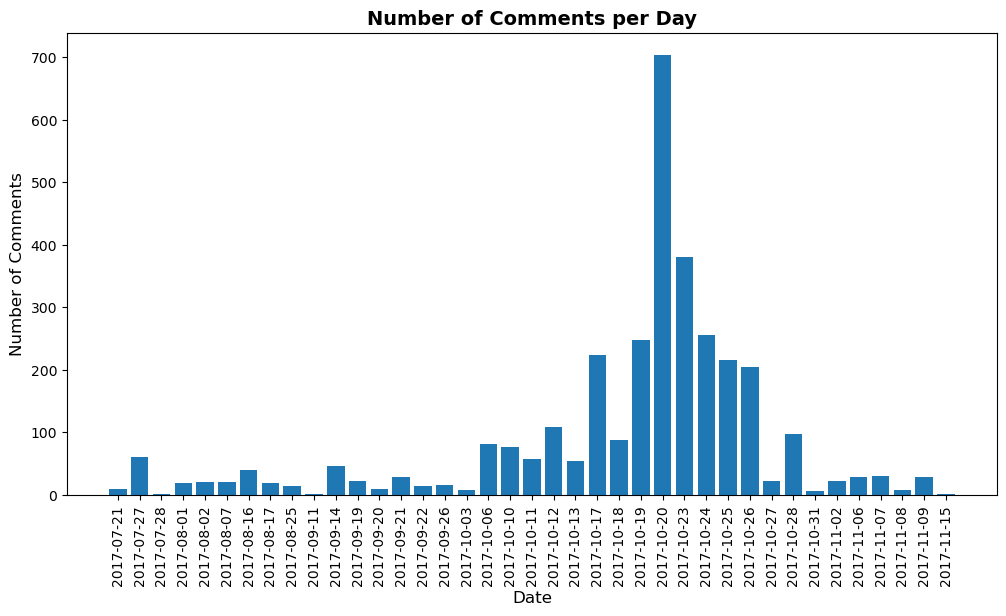

In [24]:
comment_df['posted_date'] = pd.to_datetime(comment_df['Posted Date'])
comment_df['month'] = comment_df.posted_date.dt.month
comment_df['day'] = comment_df.posted_date.dt.day
daily_counts = comment_df['posted_date'].value_counts().sort_index()
# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(daily_counts.index.strftime('%Y-%m-%d'), daily_counts.values)
plt.title('Number of Comments per Day', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Comments', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [25]:
# Filter to January 2, 2024 using string date, Couldn't easily determine what caused the spike in comments on 10/20. A fair number were apart of the cooridated campaign but that alone doesnt explain the spike
specific_date = '2017-10-20'
filtered_df = comment_df[comment_df['posted_date'].dt.date == pd.to_datetime(specific_date).date()]



# Sentiment Analysis and Theme Extraction

In [26]:

#Using an open source Summarizer to shorten longer comments
summarized_file_path = "data/summarized_df.parquet"
if os.path.exists(summarized_file_path):
    #so we don't rerun if file has already been created, as summerization can take several minutes to complete
    print("file exists")
    comment_df = pd.read_parquet(summarized_file_path)
else:
    # Load a pre-trained summarization pipeline 
    summarizer = pipeline("summarization", model= 'sshleifer/distilbart-cnn-12-6')
    
    ret = []
    for i in tqdm(range(len(comment_df))):
        row = comment_df.iloc[i]
        try:
            #only summarizing comments that are greater than 1024 characters long
            if len(row.Comment)>1024:
                short_comment = summarizer(row.Comment, max_length = 200, min_length = 50, do_sample = True)[0]['summary_text']
            else:
                short_comment = row.Comment
        except:
            #there are some instances where the comment is too long for the summarizer and it breaks for now we are going to effectivly drop the comment, in other instances it would be better to chuck the commenets into parts and then concatnate the summaries together
            
            short_comment = ""

        ret.append(short_comment)
    comment_df['short_comment'] = ret
    comment_df.reset_index(inplace=True, drop=True)
    comment_df = comment_df[comment_df.short_comment != ""]
    comment_df.to_parquet(summarized_file_path)

file exists


In [27]:
comment_df

,Document ID,Agency ID,Docket ID,Tracking Number,Document Type,Posted Date,Is Withdrawn?,Federal Register Number,FR Citation,Title,Comment Start Date,Comment Due Date,Allow Late Comments,Comment on Document ID,Effective Date,Implementation Date,Postmark Date,Received Date,Author Date,Related RIN(s),Authors,CFR,Abstract,Legacy ID,Media,Document Subtype,Exhibit Location,Exhibit Type,Additional Field 1,Additional Field 2,Topics,Duplicate Comments,OMB/PRA Approval Number,Page Count,Page Length,Paper Width,Special Instructions,Source Citation,Start End Page,Subject,First Name,Last Name,City,State/Province,Zip/Postal Code,Country,Organization Name,Submitter Representative,Representative's Address,"Representative's City, State & Zip",Government Agency,Government Agency Type,Comment,Category,Restrict Reason Type,Restrict Reason,Reason Withdrawn,Content Files,Attachment Files,"Display Properties (Name, Label, Tooltip)",comment_char_length,comment_word_length,short_comment
0,EPA-R10-OW-2017-0369-0003,EPA,EPA-R10-OW-2017-0369,1k1-8xlx-cjp9,Public Submission,2017-07-21T04:00Z,False,None,NaN,Anonymous public comment,None,None,False,EPA-R10-OW-2017-0369-0001,NaN,NaN,2017-07-19T04:00Z,2017-07-19T04:00Z,None,NaN,None,NaN,None,NaN,None,Public Comment,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0.0,0.0,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Subject: EPA-R10-OW-2017-0369 Preserve Bristol...,NaN,NaN,NaN,None,None,None,"pageCount, Page Count, Number of pages In the ...",1915,280,The Pebble deposit will destroy 94 miles of s...
1,EPA-R10-OW-2017-0369-0004,EPA,EPA-R10-OW-2017-0369,1k1-8xm3-v0xi,Public Submission,2017-07-21T04:00Z,False,None,NaN,Anonymous public comment,None,None,False,EPA-R10-OW-2017-0369-0001,NaN,NaN,2017-07-19T04:00Z,2017-07-19T04:00Z,None,NaN,None,NaN,None,NaN,None,Public Comment,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0.0,0.0,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Do not let this happen.. Copper mining need no...,NaN,NaN,NaN,None,None,None,"pageCount, Page Count, Number of pages In the ...",102,19,Do not let this happen.. Copper mining need no...
2,EPA-R10-OW-2017-0369-0005,EPA,EPA-R10-OW-2017-0369,1k1-8xmd-18hj,Public Submission,2017-07-21T04:00Z,False,None,NaN,Anonymous public comment,None,None,False,EPA-R10-OW-2017-0369-0001,NaN,NaN,2017-07-20T04:00Z,2017-07-20T04:00Z,None,NaN,None,NaN,None,NaN,None,Public Comment,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0.0,0.0,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This area is too important to salmon fishing t...,NaN,NaN,NaN,None,None,None,"pageCount, Page Count, Number of pages In the ...",108,21,This area is too important to salmon fishing t...
3,EPA-R10-OW-2017-0369-0006,EPA,EPA-R10-OW-2017-0369,1k1-8xmg-in4u,Public Submission,2017-07-21T04:00Z,False,None,NaN,Anonymous public comment,None,None,False,EPA-R10-OW-2017-0369-0001,NaN,NaN,2017-07-20T04:00Z,2017-07-20T04:00Z,None,NaN,None,NaN,None,NaN,None,Public Comment,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0.0,0.0,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,An open pit copper mine like the Pebble Mine l...,NaN,NaN,NaN,None,None,None,"pageCount, Page Count, Number of pages In the ...",207,34,An open pit copper mine like the Pebble Mine l...
4,EPA-R10-OW-2017-0369-0007,EPA,EPA-R10-OW-2017-0369,1k1-8xmh-abl7,Public Submission,2017-07-21T04:00Z,False,None,NaN,Anonymous public comment,None,None,False,EPA-R10-OW-2017-0369-0001,NaN,NaN,2017-07-20T04:00Z,2017-07-20T04:00Z,None,NaN,None,NaN,None,NaN,None,Public Comment,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0.0,0.0,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This is a big deal. The Bristol Bay watershed ...,NaN,NaN,NaN,None,None,None,"pageCount, Page Count, Number of pages In the ...",167,31,This is a big deal. The Bristol Bay watershed ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [28]:
#RUnning Sentiment Analysis on those Comments
from transformers import pipeline
sent_path = 'data/sent_df.parquet'

if os.path.exists(sent_path):
    print('path exists')
    sent_df = pd.read_parquet(sent_path)
else:
    sentiment_pipeline = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest", device='cpu',)
    sent_ret = sentiment_pipeline(list(comment_df['short_comment']), truncation= True, max_length = 512)
    sent_df = pd.DataFrame(sent_ret)
    sent_df['short_comment'] = comment_df['short_comment']
    sent_df = pd.concat([sent_df,comment_df[['Document ID', 'Comment']]], axis=1)
    sent_df.loc[sent_df.label == 'negative', 'score'] = sent_df.loc[sent_df.label == 'negative', 'score']*-1

    sent_df.to_parquet(sent_path)

path exists


In [29]:
#Sentitment of the comments according to the out of the box classifier are largly negative
pd.DataFrame(sent_df.label.value_counts(True))*100

,proportion
label,
negative,66.733601
neutral,26.941098
positive,6.325301


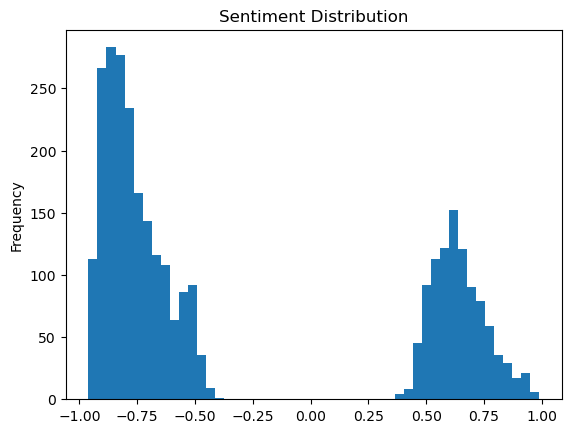

In [30]:

sent_df.label.value_counts(True)
sent_df.score.mean()
sent_df.score.plot(kind = 'hist', bins = 50)
# plt.grid(True)
plt.title('Sentiment Distribution')
plt.show()

In [31]:
# predicting Negative sentiment 67% of the time, and when it does it does with high confidience,
#predictued Positive sentiment only 6% of the time and has a lower confidence.

In [32]:
sent_df[sent_df.short_comment.str.contains('keep')].label.value_counts()

label
negative    71
neutral     37
positive    15
Name: count, dtype: int64

In [33]:
sent_df[sent_df.short_comment.str.contains('remove')].label.value_counts()

label
negative    70
neutral     21
positive     2
Name: count, dtype: int64

In [34]:
sent_df[sent_df.short_comment.str.contains('support')].label.value_counts()

label
neutral     245
negative    210
positive     45
Name: count, dtype: int64

In [35]:
sent_df[sent_df.short_comment.str.contains('oppose')].label.value_counts()

label
negative    356
neutral     103
positive      1
Name: count, dtype: int64

In [36]:
sent_df[(sent_df.short_comment.str.contains('keep'))].short_comment.values

array(['The long term environmental impact risks are too great to be chasing short term profits! Keep our sustainable supply of wild  salmon safe, and keep supporting all the local and national companies who rely on these lands and waters for survival by preventing this from becoming a deposit site!',
       ' The Pebble Mine in Bristol Bay is perilous to the American fishing industry that has been on those lands since the start of our republic . I implore you to protect Bristol Bay, protect American jobs, and keep American money and food safe . Do not take the risk - it is much too large and not in the interest of Americans .',
       "I am adamantly against the EPA's withdrawing protections from the Bristol Bay area to allow mining there.  As you know, the economic and environment risks are just too high.  We now know that runoff from the mine would affect thousands of local jobs, would affect local protein consumption, would affect salmon production worldwide, would affect the envir

In [37]:

zero_path = "data/zero_shot_result_df.parquet"
if os.path.exists(zero_path):
    print('path exists')
    result_df = pd.read_parquet(zero_path)
else:
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device = 'cpu')
    # sequence_to_classify = "The Bristol Bay watershed supports the largest sockeye salmon run in the world, producing approximately 46% of the world's wild sockeye harvest . Construction of the Pebble deposit will destroy 94 miles of salmon streams and 5,350 acres of wetlands, lakes and ponds."
    candidate_labels = ["for", "against"]
    # result = classifier(sequence_to_classify, candidate_labels)
    # print(result)
    comment_df = comment_df[comment_df.short_comment.str.len()>0]
    result = classifier(list(comment_df.short_comment),candidate_labels)
    result_df = pd.DataFrame(result)
    result_df['label'] = result_df.labels.apply(lambda x: x[0])
    result_df['prob'] = result_df.scores.apply(lambda x: x[0])
    result_df.loc[result_df.label == 'against','prob'] = result_df.loc[result_df.label == 'against','prob']*-1
    comment_df.reset_index(inplace=True, drop=True)
    result_df = pd.concat([result_df,comment_df[['Document ID','Comment']]], axis = 1)
    result_df.to_parquet(zero_path)


path exists


In [38]:
result_df['label'].value_counts(True)

label
against    0.845382
for        0.154618
Name: proportion, dtype: float64

Text(0.5, 1.0, 'Zero Shot Classification Probability Distribution')

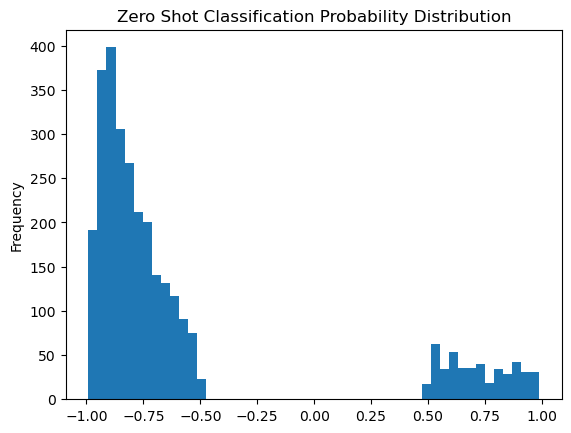

In [39]:
result_df.prob.plot(kind = 'hist', bins = 50)
plt.title("Zero Shot Classification Probability Distribution")

In [40]:
sent_df.head()

,label,score,short_comment,Document ID,Comment
0,neutral,0.495293,The Pebble deposit will destroy 94 miles of s...,EPA-R10-OW-2017-0369-0003,Subject: EPA-R10-OW-2017-0369 Preserve Bristol...
1,negative,-0.889423,Do not let this happen.. Copper mining need no...,EPA-R10-OW-2017-0369-0004,Do not let this happen.. Copper mining need no...
2,negative,-0.731599,This area is too important to salmon fishing t...,EPA-R10-OW-2017-0369-0005,This area is too important to salmon fishing t...
3,negative,-0.854966,An open pit copper mine like the Pebble Mine l...,EPA-R10-OW-2017-0369-0006,An open pit copper mine like the Pebble Mine l...
4,negative,-0.649826,This is a big deal. The Bristol Bay watershed ...,EPA-R10-OW-2017-0369-0007,This is a big deal. The Bristol Bay watershed ...


In [41]:
m_df =pd.merge(sent_df[['Document ID','label','score']], result_df[['Document ID','label','prob']], on ='Document ID')

In [42]:
m_df.groupby(['label_x', 'label_y']).size()

label_x   label_y
negative  against    1899
          for          95
neutral   against     572
          for         233
positive  against      55
          for         134
dtype: int64

In [43]:
result = m_df.groupby(['label_x', 'label_y']).size().unstack(fill_value=0)

# Calculate percentages
result_pct = result.div(result.sum(axis=1), axis=0).mul(100).round(2)

print("Method 3 - Counts and Percentages:")
print("Counts:")
print(result)
print("\nPercentages:")
print(result_pct)

Method 3 - Counts and Percentages:
Counts:
label_y   against  for
label_x               
negative     1899   95
neutral       572  233
positive       55  134

Percentages:
label_y   against    for
label_x                 
negative    95.24   4.76
neutral     71.06  28.94
positive    29.10  70.90


In [44]:


def topic_modeling_sklearn(documents, num_topics=5):
    """
    Perform topic modeling using scikit-learn
    """
    
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    
    dtm = vectorizer.fit_transform(documents)
        
    model = LatentDirichletAllocation(
        n_components=num_topics, 
        random_state=42,
        max_iter=10)
   
    # Fit model
    model.fit(dtm)
    
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    return model, dtm, feature_names

def display_topics(model, feature_names, no_top_words=10):
    """Display topics with top words"""
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

# Example usage

# LDA with scikit-learn
print("Topics:")
model_lda, dtm, feature_names = topic_modeling_sklearn(result_df[result_df.label == 'against'].sequence , num_topics=3)
display_topics(model_lda, feature_names)


Topics:
Topic 1:
bristol bay proposed salmon determination pebble jobs wild alaska fisheries

Topic 2:
salmon bay bristol mining area pebble people jobs world sockeye

Topic 3:
epa mining water area clean pebble bay protect environment bristol



In [45]:
print("Topics:")
model_lda, dtm, feature_names = topic_modeling_sklearn(result_df[result_df.label == 'for'].sequence, num_topics=3)
display_topics(model_lda, feature_names)


Topics:
Topic 1:
epa pebble determination proposed bristol bay mining clean alaska process

Topic 2:
salmon bay bristol protect wild world alaska proposed fishery water

Topic 3:
pebble alaska project mining process jobs proposed people state epa



In [46]:
for_df  = result_df[result_df.label == 'for'].sort_values('prob', ascending=False)

In [47]:
for_str = " ".join(for_df.head(20).sample(5, random_state = 0).sequence)
summarizer = pipeline("summarization", model= 'sshleifer/distilbart-cnn-12-6', device = 'cpu')
summarizer(for_str)

Device set to use cpu


[{'summary_text': " Pro Pebble Mine is a good thing for all Alaskans, and especially for the economy of our struggling burrough. We can't just rely on drilling for oil, or salmon fishing for an economy. We need to expand our mineral resources also. Pro Pebble will make America great Again ."}]

In [48]:
summarizer = pipeline("summarization", model= 'sshleifer/distilbart-cnn-12-6', device  = 'cpu')
for_str = " ".join(result_df[result_df.label == 'against'].sample(10, random_state=0).sequence)
summarizer(for_str)

Device set to use cpu


[{'summary_text': ' I oppose Pebble Mine and voice my support for sustainable jobs in Alaska, traditional ways of life for indigenous people, and the protection of habitat for the largest Pacific salmon runs in the world . Please retain protections for Bristol Bay from the proposed Pebble Mine, which poses significant environmental risk to a highly-productive and sustainable fishery .'}]